In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from gnns import GINNet
import copy

In [2]:
# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
with open('../data/qm9_train_pyg_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('../data/qm9_test_pyg_data.pkl', 'rb') as f:
    test_data = pickle.load(f) 

In [4]:
# create validation set
train_data, val_data = random_split(train_data, [int(0.8*len(train_data)), len(train_data)-int(0.8*len(train_data))])

# Data loader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## GCN

In [7]:
from gnns import GCN
model = GCN(num_node_features=4, hidden_channels=32, num_layers=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()
num_epochs =70


In [9]:
# Training
model.train()
prev_train_loss = float('inf')
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_state_dict = None  # Initialize to None
test_interval = 5
start_time = time.time()
epoch_times = []  # List to store time for each epoch

for epoch in range(1, num_epochs+1):  # You can adjust the number of epochs
    epoch_loss = []
    for data in train_loader:
        data = data.to(device)
        data.y = data.y[:, 0].view(-1, 1) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        # Accumulate the loss for each batch
        epoch_loss.append(loss.item())

    # Calculate the average training loss for the epoch
    average_train_loss =  np.mean(epoch_loss)
    train_losses.append(average_train_loss)  # Save training loss for plotting

    # Print training loss every epoch
    print(f'Epoch {epoch}, Average Training Loss: {average_train_loss}')

    # Validation
    model.eval()
    val_loss = []
    num_val_batches = len(val_loader)
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data.y = data.y[:, 0].view(-1, 1)
            output = model(data)
            val_loss.append(criterion(output, data.y).item())

    average_val_loss = np.mean(val_loss)
    val_losses.append(average_val_loss)

    # Print validation loss every epoch
    print(f'Epoch {epoch}, Average Validation Loss: {average_val_loss}')

    # Save the best model based on validation loss
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state_dict = model.state_dict()

    # Test the model at test_interval epochs
    if epoch % test_interval == 0:
        total_test_loss = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                data.y = data.y[:, 0].view(-1, 1)
                output = model(data)
                total_test_loss.append(criterion(output, data.y).item())

        average_test_loss = np.mean(total_test_loss)
        test_losses.append(average_test_loss)  # Save test loss for plotting
        print(f'Epoch {epoch}, Average Test Loss: {average_test_loss}')

    # Record time for the epoch
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Print the time taken for the epoch
    print(f'Epoch {epoch}, Time: {epoch_time}')

# Print the final average test loss
print(f'Final Average Test Loss: {average_test_loss}')

# Save the best model
torch.save(best_model_state_dict, 'best_model_gcn.pt')

# Record time and losses
losses_dict_gcn = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,
    'best_val_loss': best_val_loss,
    'epoch_times': epoch_times,  # List of times for each epoch
}

# Save the losses_dict as a pickle file
with open('losses_dict_gcn.pkl', 'wb') as f:
    pickle.dump(losses_dict_gcn, f)

Epoch 1, Average Training Loss: 0.04585933103565349
Epoch 1, Average Validation Loss: 0.03467761387151701
Epoch 1, Time: 4.4474921226501465
Epoch 2, Average Training Loss: 0.03412551577172137
Epoch 2, Average Validation Loss: 0.03366425967523976
Epoch 2, Time: 8.136376857757568
Epoch 3, Average Training Loss: 0.03373285057084845
Epoch 3, Average Validation Loss: 0.03371499189072185
Epoch 3, Time: 11.858636856079102
Epoch 4, Average Training Loss: 0.033530166000127794
Epoch 4, Average Validation Loss: 0.034009836574710864
Epoch 4, Time: 15.547490119934082
Epoch 5, Average Training Loss: 0.03345832645350339
Epoch 5, Average Validation Loss: 0.03321964045365652
Epoch 5, Average Test Loss: 0.03327526412542584
Epoch 5, Time: 19.588151216506958
Epoch 6, Average Training Loss: 0.03341818760759783
Epoch 6, Average Validation Loss: 0.03433659465776549
Epoch 6, Time: 23.264711141586304
Epoch 7, Average Training Loss: 0.033301439017846886
Epoch 7, Average Validation Loss: 0.03335988954222076
Epoc

In [12]:
min(losses_dict_gcn['test_losses'])

0.03120671657537951

## GAT

In [6]:
from gnns import GATNet
# Instantiate the model
model = GATNet(4, hidden_channels=64, num_layers=3, heads=8).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()
num_epochs =70

In [8]:
# Training
model.train()
prev_train_loss = float('inf')
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_state_dict = None  # Initialize to None
test_interval = 5
start_time = time.time()
epoch_times = []  # List to store time for each epoch

for epoch in range(1, num_epochs+1):  # You can adjust the number of epochs
    epoch_loss = []
    for data in train_loader:
        data = data.to(device)
        data.y = data.y[:, 0].view(-1, 1) 
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        # Accumulate the loss for each batch
        epoch_loss.append(loss.item())

    # Calculate the average training loss for the epoch
    average_train_loss =  np.mean(epoch_loss)
    train_losses.append(average_train_loss)  # Save training loss for plotting

    # Print training loss every epoch
    print(f'Epoch {epoch}, Average Training Loss: {average_train_loss}')

    # Validation
    model.eval()
    val_loss = []
    num_val_batches = len(val_loader)
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data.y = data.y[:, 0].view(-1, 1)
            output = model(data.x, data.edge_index, data.batch)
            val_loss.append(criterion(output, data.y).item())

    average_val_loss = np.mean(val_loss)
    val_losses.append(average_val_loss)

    # Print validation loss every epoch
    print(f'Epoch {epoch}, Average Validation Loss: {average_val_loss}')

    # Save the best model based on validation loss
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state_dict = model.state_dict()

    # Test the model at test_interval epochs
    if epoch % test_interval == 0:
        total_test_loss = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                data.y = data.y[:, 0].view(-1, 1)
                output = model(data.x, data.edge_index, data.batch)
                total_test_loss.append(criterion(output, data.y).item())

        average_test_loss = np.mean(total_test_loss)
        test_losses.append(average_test_loss)  # Save test loss for plotting
        print(f'Epoch {epoch}, Average Test Loss: {average_test_loss}')

    # Record time for the epoch
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Print the time taken for the epoch
    print(f'Epoch {epoch}, Time: {epoch_time}')

# Print the final average test loss
print(f'Final Average Test Loss: {average_test_loss}')

# Save the best model
torch.save(best_model_state_dict, 'best_model_gat.pt')

# Record time and losses
losses_dict = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,
    'best_val_loss': best_val_loss,
    'epoch_times': epoch_times,  # List of times for each epoch
}

# Save the losses_dict as a pickle file
with open('losses_dict_gat.pkl', 'wb') as f:
    pickle.dump(losses_dict, f)

Epoch 1, Average Training Loss: 0.12390176882806993
Epoch 1, Average Validation Loss: 0.09314146909921889
Epoch 1, Time: 5.790978670120239
Epoch 2, Average Training Loss: 0.034628878627589205
Epoch 2, Average Validation Loss: 0.03306798421082988
Epoch 2, Time: 11.259921073913574
Epoch 3, Average Training Loss: 0.03343867189096694
Epoch 3, Average Validation Loss: 0.03288847039498034
Epoch 3, Time: 16.728816509246826
Epoch 4, Average Training Loss: 0.03349710840312456
Epoch 4, Average Validation Loss: 0.03240342277580153
Epoch 4, Time: 22.172588348388672
Epoch 5, Average Training Loss: 0.03315061753899451
Epoch 5, Average Validation Loss: 0.036057686581025046
Epoch 5, Average Test Loss: 0.03633351587844126
Epoch 5, Time: 28.16582155227661
Epoch 6, Average Training Loss: 0.033363081324870224
Epoch 6, Average Validation Loss: 0.03210229768600098
Epoch 6, Time: 33.67289137840271
Epoch 7, Average Training Loss: 0.03294627738265407
Epoch 7, Average Validation Loss: 0.03482651863266867
Epoch 

In [9]:
losses_dict['best_val_loss']

0.030566889763114943

## GIN

In [27]:
# Instantiate the model
model = GINNet(4, hidden_channels=64, num_layers=3).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()
num_epochs =70


In [28]:
# Training
prev_train_loss = float('inf')
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_state_dict = None  # Initialize to None
test_interval = 5
start_time = time.time()
epoch_times = []  # List to store time for each epoch

for epoch in range(1, num_epochs+1):  # You can adjust the number of epochs
    epoch_loss = []
    model.train()
    for data in train_loader:
        data = data.to(device)
        data.y = data.y[:, 0].view(-1, 1) #/ 27.2114
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        # Accumulate the loss for each batch
        epoch_loss.append(loss.item())

    # Calculate the average training loss for the epoch
    average_train_loss = np.mean(epoch_loss)
    train_losses.append(average_train_loss)  # Save training loss for plotting

    # Print training loss every epoch
    print(f'Epoch {epoch}, Average Training Loss: {average_train_loss}')

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data.y = data.y[:, 0].view(-1, 1) #/ 27.2114
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            val_loss.append(criterion(output, data.y).item())
    average_val_loss = np.mean(val_loss)
    val_losses.append(average_val_loss)

    # Print validation loss every epoch
    print(f'Epoch {epoch}, Average Validation Loss: {average_val_loss}')

    # Save the best model based on validation loss
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state_dict = model.state_dict()

    # Test the model at test_interval epochs
    if epoch % test_interval == 0:
        total_test_loss = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                data.y = data.y[:, 0].view(-1, 1) #/ 27.2114
                output = model(data.x, data.edge_index, data.edge_attr, data.batch)
                total_test_loss.append(criterion(output, data.y).item())

        average_test_loss = np.mean(total_test_loss)
        test_losses.append(average_test_loss)  # Save test loss for plotting
        print(f'Epoch {epoch}, Average Test Loss: {average_test_loss}')

    # Record time for the epoch
    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Print the time taken for the epoch
    print(f'Epoch {epoch}, Time: {epoch_time}')

# Print the final average test loss
print(f'Final Average Test Loss: {average_test_loss}')

# Save the best model
torch.save(best_model_state_dict, 'best_model.pt')

# Record time and losses
losses_dict_gin = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,
    'best_val_loss': best_val_loss,
    'epoch_times': epoch_times,  # List of times for each epoch
}

# Save the losses_dict as a pickle file
with open('losses_dict_gin.pkl', 'wb') as f:
    pickle.dump(losses_dict_gin, f)

Epoch 1, Average Training Loss: 0.03611887380086033
Epoch 1, Average Validation Loss: 0.03438346591536646
Epoch 1, Time: 3.9544789791107178
Epoch 2, Average Training Loss: 0.03259030484057815
Epoch 2, Average Validation Loss: 0.03106646971018226
Epoch 2, Time: 7.9030921459198
Epoch 3, Average Training Loss: 0.031404965565792774
Epoch 3, Average Validation Loss: 0.030882476124340894
Epoch 3, Time: 11.831494331359863
Epoch 4, Average Training Loss: 0.030816740088707564
Epoch 4, Average Validation Loss: 0.030064752059323446
Epoch 4, Time: 15.764144897460938
Epoch 5, Average Training Loss: 0.030546463071214443
Epoch 5, Average Validation Loss: 0.029985189812366295
Epoch 5, Average Test Loss: 0.030192360896798012
Epoch 5, Time: 20.027106285095215
Epoch 6, Average Training Loss: 0.030348063095022512
Epoch 6, Average Validation Loss: 0.030135061897376858
Epoch 6, Time: 23.977689266204834
Epoch 7, Average Training Loss: 0.030234665445835387
Epoch 7, Average Validation Loss: 0.02995348754265005

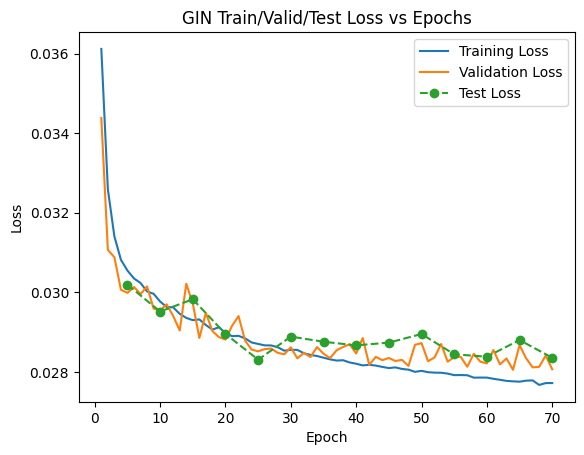

In [29]:
# Plotting
epochs_train = range(1, 71)  # Adjust the range based on the actual number of epochs you used
epochs_val = range(1, 71)  # Adjust the range based on the actual number of epochs you used
plt.plot(epochs_train, train_losses, label='Training Loss')
plt.plot(epochs_val, val_losses, label='Validation Loss')
plt.plot(range(test_interval, 71, test_interval), test_losses, label='Test Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GIN Train/Valid/Test Loss vs Epochs')
plt.legend()
plt.savefig("loss.png")
plt.show()


In [21]:
best_testLoss = min(losses_dict_gin['test_losses'])
print('Best Test Loss:', best_testLoss)

losses_dict_gin.keys()

Best Test Loss: 0.0283783758872921


dict_keys(['train_losses', 'val_losses', 'test_losses', 'best_val_loss', 'epoch_times'])

In [22]:
print('Best Validation Loss:', losses_dict_gin['best_val_loss'])

Best Validation Loss: 0.028118722741960218


In [49]:
from gnns import DeeperGCN

# Instantiate the model
model_GCN = DeeperGCN(hidden_channels=16, num_layers=3,
                      num_edge_features=3, num_node_features=4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()

In [50]:
# Initialize the best model metrics
best_val_loss = float('inf')
best_model_state_dict = None  # Initialize to None

# Lists to store metrics
train_losses = []
val_losses = []
test_losses = []
epoch_durations = []  # List to store duration for each epoch
total_duration = 0  # Variable to store the total training time
saved_test_losses = []  # To store test losses every 5 epochs

# Training loop
for epoch in range(1, num_epochs+1):
    epoch_loss = []
    epoch_start_time = time.time()
    # Training
    model.train()
    total_train_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.y = data.y[:, 0].view(-1, 1)
        optimizer.zero_grad()
        
        out = model_GCN(data.x, data.edge_index, data.edge_attr, data.batch).squeeze().unsqueeze(1)

        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    average_train_loss = np.mean(epoch_loss)
    print(f'Epoch {epoch}, Average Training Loss: {average_train_loss}')
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data.y = data.y[:, 0].view(-1, 1)
            out = model_GCN(data.x, data.edge_index, data.edge_attr, data.batch).squeeze().unsqueeze(1)
            loss = criterion(out, data.y)
            val_loss.append(loss.item())
    average_val_loss = np.mean(val_loss)
    print(f'Epoch {epoch}, Average Validation Loss: {average_val_loss}')
    val_losses.append(average_val_loss)

    # Test after each epoch and save the test loss every 5 epochs
    if epoch % test_interval == 0:
        test_loss = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                data.y = data.y[:, 0].view(-1, 1) 
                out = model_GCN(data.x, data.edge_index, data.edge_attr, data.batch).squeeze().unsqueeze(1)
                loss = criterion(out, data.y)
                test_loss.append(loss.item())
        average_test_loss = np.mean(test_loss)
        test_losses.append(average_test_loss)

    # Update the best model based on validation loss
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state_dict = copy.deepcopy(model.state_dict())

    # Record epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_durations.append(epoch_duration)
    total_duration += epoch_duration

# End of training
print(f'Total training duration: {total_duration:.2f} seconds')

# Save the best model
torch.save(best_model_state_dict, 'best_model.pth')

# Save training metrics
losses_dict_DGCN = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_losses': test_losses,  # Include all test losses
    'saved_test_losses': saved_test_losses,  # Only include test losses saved every 5 epochs
    'best_val_loss': best_val_loss,
    'epoch_durations': epoch_durations,
    'total_duration': total_duration
}

with open('losses_dict_DGCN.pkl', 'wb') as f:
    pickle.dump(losses_dict_DGCN, f)


Epoch 1, Average Training Loss: 0.7883260808243657
Epoch 1, Average Validation Loss: 0.7886523058805516
Epoch 2, Average Training Loss: 0.788332692676822
Epoch 2, Average Validation Loss: 0.7887055227365444
Epoch 3, Average Training Loss: 0.788449426123638
Epoch 3, Average Validation Loss: 0.7890138228734335
Epoch 4, Average Training Loss: 0.7880666609631469
Epoch 4, Average Validation Loss: 0.789082389975351
Epoch 5, Average Training Loss: 0.7883129800392302
Epoch 5, Average Validation Loss: 0.788719514059642
Epoch 6, Average Training Loss: 0.7882016971411294
Epoch 6, Average Validation Loss: 0.7891498126050152


KeyboardInterrupt: 